In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
import seaborn as sns
import random
import matplotlib.patches as patches
import tensorflow.image
from sklearn.model_selection import train_test_split
from keras import layers, Sequential, Model, initializers, regularizers
import keras
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import learning_curve
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import random
from typing import Dict, List, Any
from itertools import product

In [ ]:
# a function to set random seed for reproducibility
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)

# True for reproducibility / flase for actual training
debug = True

if debug:
    set_random_seed(42)

In [ ]:
# changing the palette and color map of matplotlib and seaborn to a custom one

from matplotlib.colors import ListedColormap

custom_colors = sns.color_palette("flare", 3)
jco_cmap = ListedColormap(custom_colors)

sns.set_theme(palette='flare', font='Sans-Serif')
plt.style.use('Solarize_Light2')

First I will extract the data downloading it from a github repository

In [ ]:
%pwd

'/content'

In [ ]:
import urllib.request
import zipfile
import pickle

zip_url = "https://github.com/nixxdd/image_data/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "MyDrive\EXAM"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

In [ ]:
with open(data_path, 'rb') as f:
  data = pickle.load(f)

images = data['imgs']
y = data['labels']
labels = y[:,0]
bbox = y[:,1:]

Now that we have extracted the data, let's inspect out input a bit. First I will look at some of the images, afterwards I will look at our target labels and see the frequency for each class

In [ ]:
# Let's inspect our images a bit
# Images should be of shape (227, 227, 3)
print(f"Images shape: {images.shape}")
max_val = np.max(images)
print(f"max value : {max_val}, min value : {np.min(images)}")

# Let's normalize the images within the range [0,1]
images_norm = images.astype('float32') / max_val
print(f"After normalizing, max value : {np.max(images_norm)}, min value : {np.min(images_norm)}")

Images shape: (186, 227, 227, 3)
max value : 255.0, min value : 0.0
After normalizing, max value : 1.0, min value : 0.0


In [ ]:
# computing the frequency for each class
classes, counts = np.unique(labels, return_counts=True)
count = np.asarray((classes, counts)).T
freq = [(count[i, 1]/1200) * 100 for i in range(count.shape[0])]

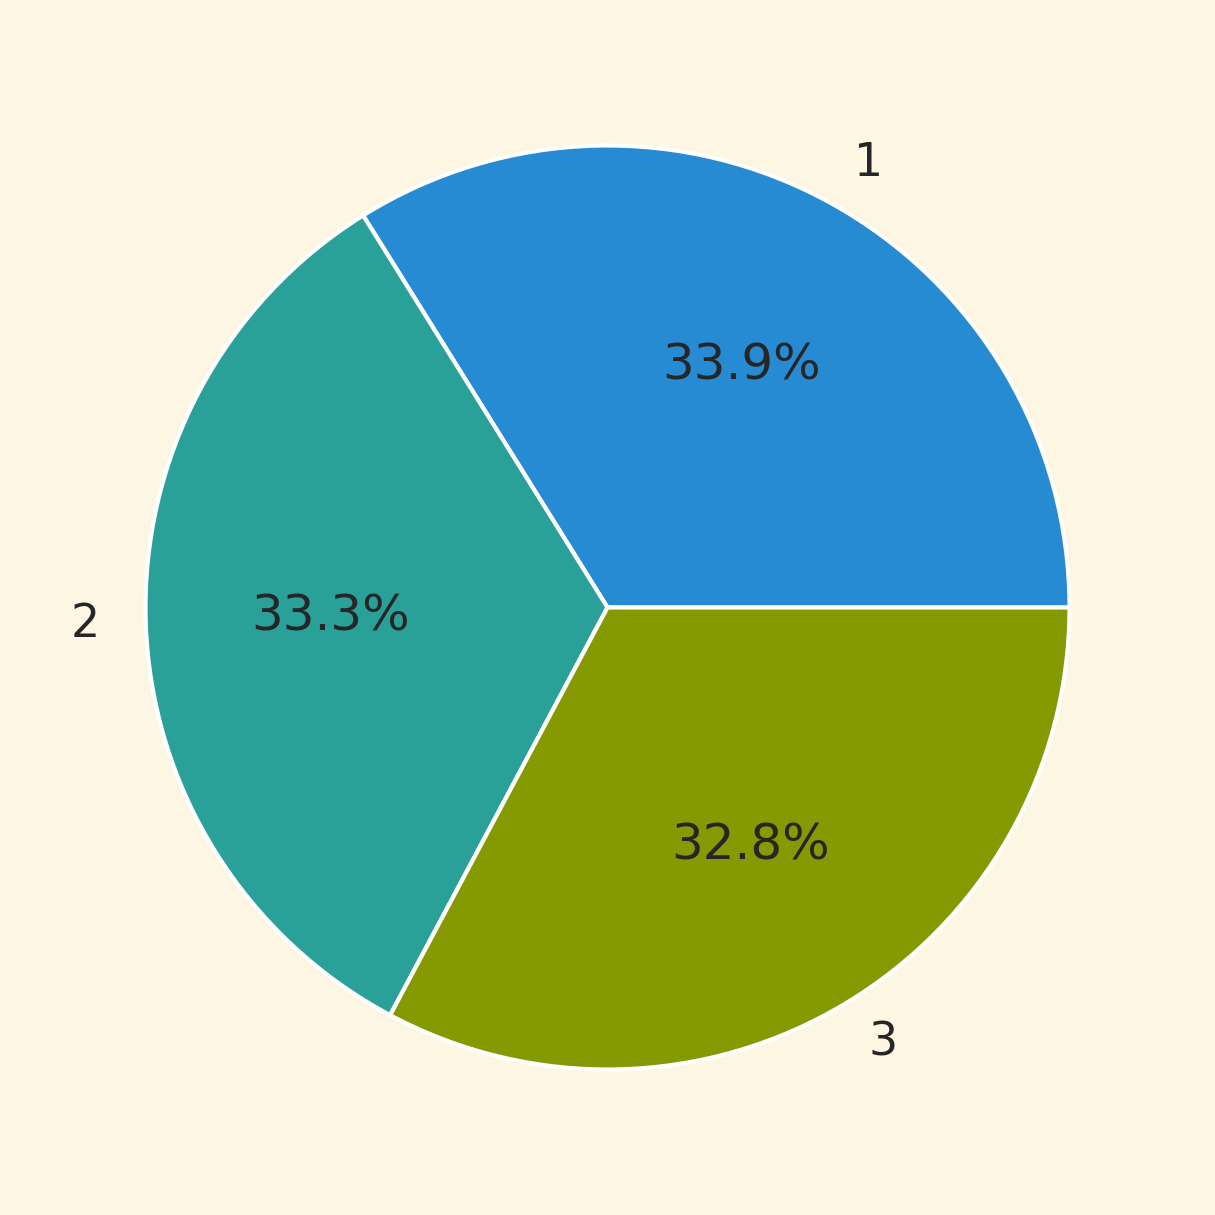

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=300)
ax.pie(freq, labels=classes, autopct='%1.1f%%')
plt.show()

I will be using the tensorflow image class for preprocessing.
The first thing I will do it's data augmentation. I will be performing mainly horizontal, vertical flipping and change in the hue of some images with some probability *p* that I will set equal to 1/3.
- **Horizontal Flipping:** I will use the keras `tf.image.flip_left_right`. For the bounding boxes because I have [x1, y1, x2, y2] where (x1, y1) are bottom left coordinates and (x2, y2) are top right coordinates I need to flip the xs two coordinate values and recompute them by doing the max number of the coordinate (227 in our case) - (the coordinate)
- **Vertical Flipping:** I will use the keras `tf.image.flip_up_down`. For the bounding boxes in this case I need to flip the ys two coordinate values and recompute them by doing the max number of the coordinate (227 in our case) - (the coordinate)
- **Change the Hue:** I will apply some change in the hue (mainly the color) of some images with some probability

*Note: All the vertical and horizontal flipping will be applied to all the images in the training set, at the end I will concatenate all of them*

This is the second point of the exam in which I decide how to preprocess and how to modify the input. In which I did the normalisation of the images (see above) and also the normalisation of the bounding boxes (plus data augmentation)

In [ ]:
class PreprocessImg():
  def __init__(self, images : np.array, labels : np.array, bboxes : np.array):
    self.images = images
    self.labels = labels
    self.bboxes = bboxes

  @staticmethod
  def normalising_bbox(bbox, width, height) -> np.array:
    """
    This function will normalise the bounding boxes to the range [0,1] by dividing by the width and height of the image
    """
    normalised_bbox = np.zeros_like(bbox, dtype=np.float32)
    for i, bb in enumerate(bbox):
      x1, y1, x2, y2 = bb
      x1_norm = x1 / width
      y1_norm = y1 / height
      x2_norm = x2 / width
      y2_norm = y2 / height
      normalised_bbox[i] = [x1_norm, y1_norm, x2_norm, y2_norm]
    return normalised_bbox

  @staticmethod
  def apply_horizontal_flip(image):
    """
    Utility function for horizontal flipping
    """
    return tf.image.flip_left_right(image)

  @staticmethod
  def apply_vertical_flip(image):
    """
    Utility function for vertcal flipping
    """
    return tf.image.flip_up_down(image)

  @staticmethod
  def apply_hue(image):
    """
    Utility function for changing the hue
    """
    return tf.image.random_hue(image, max_delta=0.3)

  @staticmethod
  def horizontal_bbox(bbox, width : int) -> np.array:
    """
    This function will flip the bounding boxes horizontally by flipping the xs coordinates and computing the new value
    """
    new_bbox = np.zeros_like(bbox, dtype=np.int32)
    for i, bb in enumerate(bbox):
        x1, y1, x2, y2 = bb
        flipped_x1 = width + 1 - x2 # Plus one because the range of our bounding boxes it's within [1, 227]
        flipped_x2 = width + 1 - x1
        new_bbox[i] = [flipped_x1, y1, flipped_x2, y2]
    return new_bbox

  @staticmethod
  def vertical_bbox(bbox, height : int) -> np.array:
    """
    This function will flip the bounding boxes vertically by flipping the ys coordinates and computing the new value
    """
    new_bbox = np.zeros_like(bbox, dtype=np.int32)
    for i, bb in enumerate(bbox):
        x1, y1, x2, y2 = bb
        flipped_y1 = height + 1 - y2
        flipped_y2 = height + 1 - y1
        new_bbox[i] = [x1, flipped_y1, x2, flipped_y2]
    return new_bbox

  def change_labels(self):
    """
    This function will change the labels to start from 0
    """
    f = lambda x: x - 1
    return f(self.labels)


  def apply_changes(self, imgs, labs, bbox):
    """
    This function will apply the data augmentation on the images
    """
    images_copy = np.copy(imgs) # doing it on a copy of our images
    height, width, _ = imgs.shape[1:]
    p = 1 / 3

    vertical_flip = np.zeros_like(images_copy, dtype=np.float32)
    horizontal_flip = np.zeros_like(images_copy, dtype=np.float32)
    hue_change = [] # will be transformed later to an np.array
    labels_hue = []
    bbox_hue = []

    # flipping all images
    for i, (img, lab, bb) in enumerate(zip(images_copy, labs, bbox)):
      vertical_flip[i] = PreprocessImg.apply_vertical_flip(img)
      horizontal_flip[i] = PreprocessImg.apply_horizontal_flip(img)
      if random.random() < p: # changing the hue with some probability p
        hue_change.append(PreprocessImg.apply_hue(img))
        labels_hue.append(lab)
        bbox_hue.append(bb)

    hue_change = np.array(hue_change, dtype=np.float32)
    labels_hue = np.array(labels_hue, dtype=np.int32)

    # getting the bboxes
    horizontal_bboxes = PreprocessImg.horizontal_bbox(bbox, width)
    vertical_bboxes = PreprocessImg.vertical_bbox(bbox, height)
    bbox_hue = np.array(bbox_hue, dtype=np.int32)

    print(f"Original images shape: {imgs.shape}")
    print(f"Hue changed images shape: {hue_change.shape}") # printing to know how many images changed in hue

    # concatenating to get all our images, labels and bboxes
    all_images = np.concatenate((imgs, vertical_flip, horizontal_flip, hue_change), axis=0)
    all_labels = np.concatenate((labs, labs, labs, labels_hue), axis=0)
    all_bboxes = np.concatenate((bbox, vertical_bboxes, horizontal_bboxes, bbox_hue), axis=0)

    print(f"Shapes of the modified dataset:")
    print(f"Images: {all_images.shape}, Labels: {all_labels.shape}, Bboxes: {all_bboxes.shape}")

    return all_images, all_labels, all_bboxes

  def preprare_dataset(self):
    """
    This function will prepare the dataset ready for the classification, by slipitting into train and test, performing data augmentation
    only on the train set and normalising the bboxes
    """
    self.labels = self.change_labels() # putting labels in the set {0,1,2}
    X_train, X_test, y_train, y_test, train_bbox, test_bbox = train_test_split(self.images, self.labels, self.bboxes, test_size=0.3, random_state=42, stratify=self.labels) # splitting into train and test
    print(f"Shapes of train and test dataset:")
    print(f"Train:\nImages: {X_train.shape}, Labels: {y_train.shape}, Bboxes: {train_bbox.shape}")
    print(f"Test:\nImages: {X_test.shape}, Labels: {y_test.shape}, Bboxes: {test_bbox.shape}")
    # Data augmentation only on the train set
    X_train_aug, y_train_aug, train_bbox_aug = self.apply_changes(X_train, y_train, train_bbox)
    # first we will plot some augmented images and their bounding boxes
    plot_images(X_train_aug, train_bbox_aug, y_train_aug, 15, shuffle=True)
    # normalising the bounding boxes
    train_bbox_norm, test_bbox_norm = (
        PreprocessImg.normalising_bbox(train_bbox_aug, X_train_aug.shape[1], X_train_aug.shape[2]),
        PreprocessImg.normalising_bbox(test_bbox, X_test.shape[1], X_test.shape[2]))
    print(f"Normalised bboxes")
    print(f"Original bboxes max / min values : {np.max(bbox)}, {np.min(bbox)}")
    print(f"Normalised bboxes max / min values : {np.max(train_bbox_norm)}, {np.min(train_bbox_norm)}")
    return X_train_aug, y_train_aug, train_bbox_norm, X_test, y_test, test_bbox_norm

In [ ]:
def denormalising_bbox(bbox : np.array, width : int, height : int) -> np.array:
  """
  This function will denormalise the bounding boxes to the original image size, useful for plotting
  """
  denormalised_bbox = np.zeros_like(bbox, dtype=np.int32)
  for i, bb in enumerate(bbox):
    x1, y1, x2, y2 = bb
    x1_denorm = int(x1 * width) # denormalising by multiplying for width and height
    y1_denorm = int(y1 * height)
    x2_denorm = int(x2 * width)
    y2_denorm = int(y2 * height)
    denormalised_bbox[i] = [x1_denorm, y1_denorm, x2_denorm, y2_denorm]
  return denormalised_bbox

def plot_images(data: np.array, bbox: np.array, labels : np.array, n: int, test = False, shuffle=False) -> None:
  """
  Plot n images with bounding boxes
  """
  # useful for inspecting our predictions
  if test:
    bbox = denormalising_bbox(bbox, data.shape[1], data.shape[2])

  # if we want to plot shuffled data
  if shuffle:
      indices = random.sample(range(len(data)), n)
      data = data[indices]
      bbox = bbox[indices]
      labels = labels[indices]
  else:
      data = data[:n]
      bbox = bbox[:n]
      labels = labels[:n]

  # getting the right number of rows and columns, because I want to plot only 5 images per row
  # if the number of images we want to plot it's less than 5 then we just need one row
  # else I need to find multiples of 5 so that the floor division gets me a number
  nrows = 1 if n <= 5 else (n + 4) // 5
  ncols = min(n, 5) # for the number of columns we either need the number of cols = to the number of images we want to plot
  # or 5 because I want to plot 5 images per row

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4), dpi=300) # setting the right figsize
  ax = ax.flatten() if n > 1 else [ax] # we need to flatten if n > 1 so we can access all the axis with just one index
  # if n = 1 then the axis it's just a one dimensional array

  for k in range(n):
      height = bbox[k][3] - bbox[k][1] # getting the width and height of the rectangle because the function Rectangle of matplotlib
      # takes the bottom left coordinates of the rectangle and extends it with respect to the width and heigth
      width = bbox[k][2] - bbox[k][0]
      rect = patches.Rectangle((bbox[k][0], bbox[k][1]), width, height, linewidth=1, edgecolor='r', fill=False)
      ax[k].imshow(data[k])
      ax[k].add_patch(rect)
      ax[k].set_title(f"Label: {labels[k]}") # Also plotting the labels for each image
      ax[k].axis('off')

  # Turn off the axes for the empty subplots
  for k in range(n, len(ax)):
      ax[k].axis('off')

  plt.tight_layout()
  plt.show()

Shapes of train and test dataset:
Train:
Images: (130, 227, 227, 3), Labels: (130,), Bboxes: (130, 4)
Test:
Images: (56, 227, 227, 3), Labels: (56,), Bboxes: (56, 4)
Original images shape: (130, 227, 227, 3)
Hue changed images shape: (48, 227, 227, 3)
Shapes of the modified dataset:
Images: (438, 227, 227, 3), Labels: (438,), Bboxes: (438, 4)


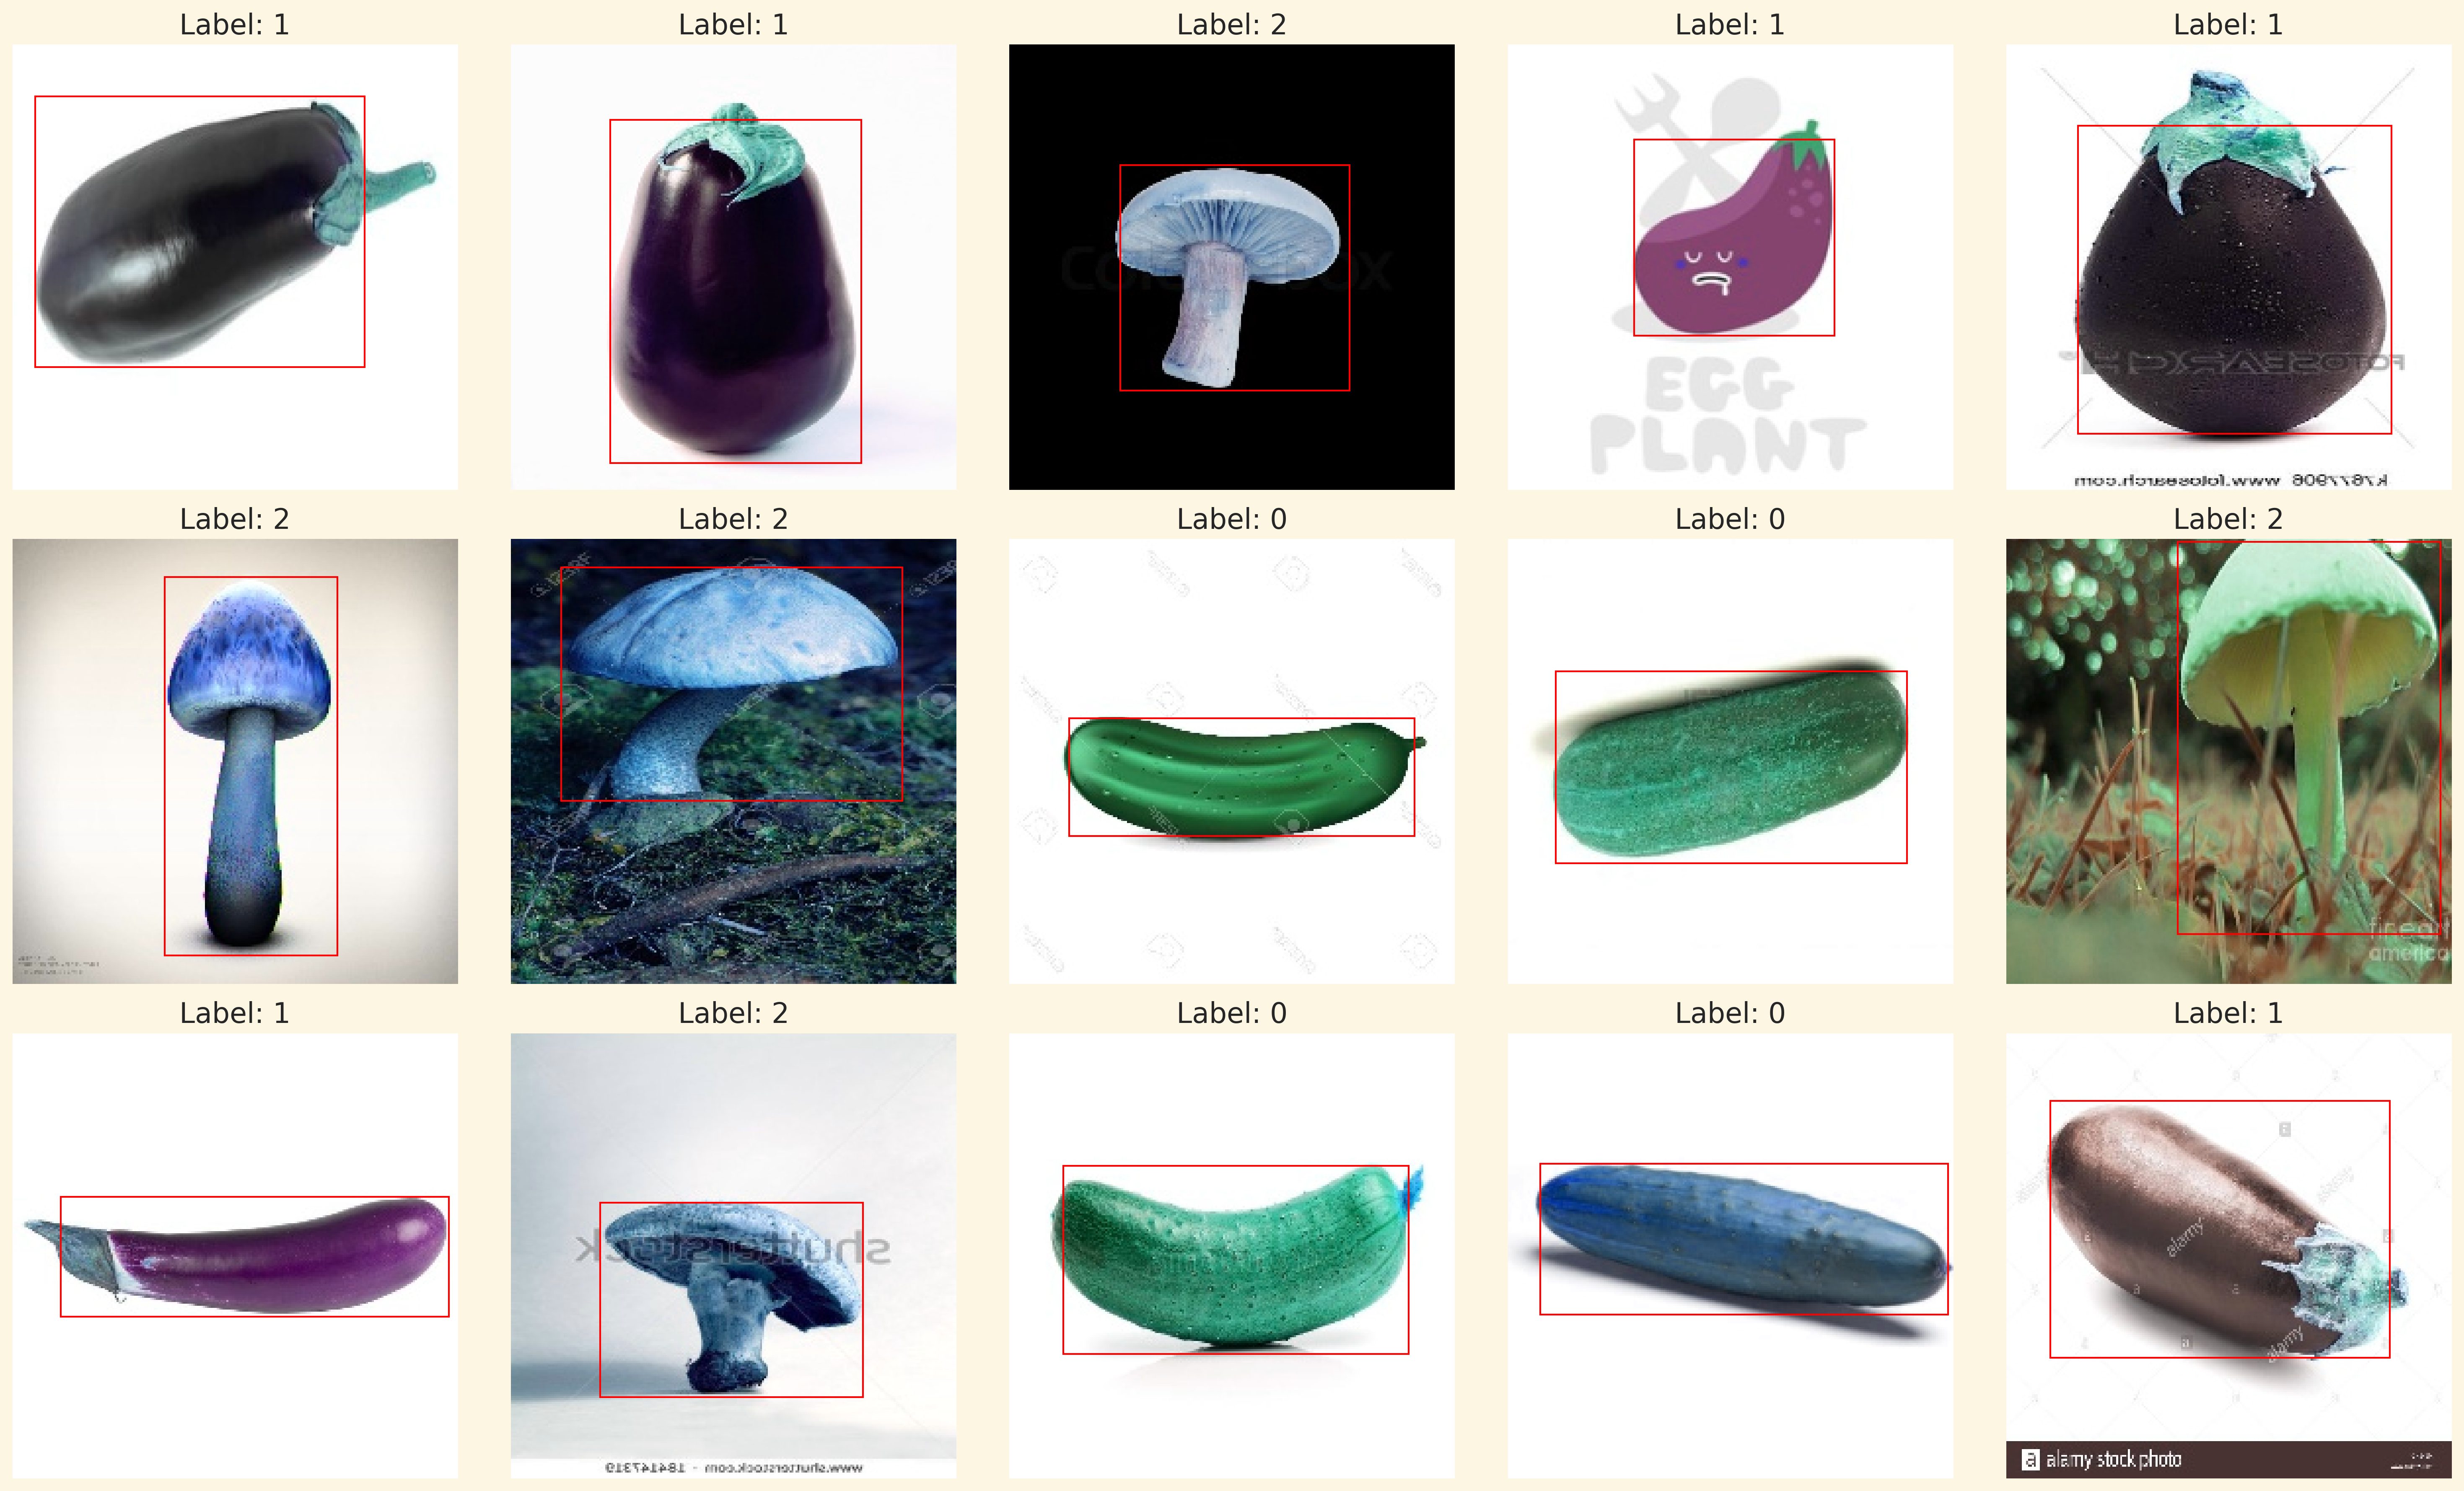

Normalised bboxes
Original bboxes max / min values : 227, 1
Normalised bboxes max / min values : 1.0, 0.0044052861630916595


In [ ]:
preprocess_img = PreprocessImg(images_norm, labels, bbox) # creating an instance of the PreprocessImg class
X_train, y_train, train_bbox, X_test, y_test, test_bbox = preprocess_img.preprare_dataset() # preparing the dataset

This is the first point of the exam in which I am defining the model.
- While also defining the model's architecture (5th point),
- I also define the activation functions (4th point)
- Loss functions, see more of the `model_compile` function (3rd point)
- Regularization, initializers (5th point)
- The optimizer of the gradient it's on the `cross_validation` function when I do the fit of the models (5th point)
All of the values are the same as I wrote on the text of the exam

In [ ]:
class ConvModel(K.Model):
  def __init__(self, input_dims : tuple, num_filters : list, hidden_units : list, dropout_rate : float, batch_size : int, learning_rate : float, num_classes : int):
    '''
    This class will create a convolutional model
    '''
    super(ConvModel, self).__init__()
    self.input_dims = input_dims
    self.num_filters = num_filters
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.num_classes = num_classes
    # initializing all the hyperparameters as if it will be useful for hyperparameter optimization

    self.model = self.create_model() # returns the model

  @property
  def num_filters(self):
    return self._num_filters

  @num_filters.setter
  def num_filters(self, value):
    """
    Setter function for the number of filters as I want it to be a list of lenght 4
    """
    if not isinstance(value, list) or len(value) != 4:
      raise ValueError("num_filters must be a list and the lenght of the tuple must be 4")
    else:
      self._num_filters = value

  def create_model(self):
    """
    Creates a convolutional model
    """
    initializer = initializers.HeNormal(seed=42) # He normal initialization
    regularizer = regularizers.l2(0.001) # L2 regularizer for the weights
    inputs = layers.Input(shape=self.input_dims, batch_size=self.batch_size)
    n1, n2, n3, n4 = self._num_filters # getting the number of filters
    # The input is (227, 227, 3)
    x = layers.Conv2D(n1, (5, 5), activation='relu', strides=1, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    # The output of the MaxPooling it's (114, 114, 3)
    x = layers.Conv2D(n2, (5, 5), activation='relu', strides=1, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    # The output of the MaxPooling it's (57, 57, 3)
    x = layers.Conv2D(n3, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    # The output of the MaxPooling it's (28, 28, 3)
    x = layers.Conv2D(n4, (2, 2), activation='relu', strides=1, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = layers.MaxPooling2D((4, 4), padding='same')(x)
    # The output of the MaxPooling it's (7, 7, 3)
    x = layers.Flatten()(x)
    x = self.dense_block(x, initializer, regularizer) # Inserting a block of dense layers
    out_classification = layers.Dense(self.num_classes, activation='softmax', name="multiclass")(x) # first output layer for classfication
    out_bbox = layers.Dense(4, activation='sigmoid', name="bboxes")(x) # second output layer for bbox coordinates (regression)
    model = Model(inputs=inputs,
                   outputs=[out_classification,out_bbox],
                   name='Conv_Model')
    return model

  def dense_block(self, x, initializer, regularizer):
    """
    This function will create a dense block of layers
    """
    for units in self.hidden_units:
            x = layers.Dropout(self.dropout_rate)(x)
            x = layers.Dense(units, activation='relu', kernel_regularizer=regularizer, kernel_initializer=initializer)(x)
    return x

  def model_compile(self):
    """
    This function will compile the model
    """
    loss_dict = {
        "multiclass": 'sparse_categorical_crossentropy', # our two losses
        "bboxes": K.losses.MeanSquaredError()
    }
    metric_dict =  {
        "multiclass": keras.metrics.SparseCategoricalAccuracy(), # metrics for the losses
        "bboxes": 'mse'
    }
    self.model.compile(
                    optimizer= tf.optimizers.Adam(learning_rate=self.learning_rate), # Adam optimizer for the gradient
                    loss=loss_dict,
                    metrics=metric_dict
    )
    return self.model

  def update_model(self, num_filters=None, hidden_units=None, dropout_rate=None, learning_rate=None):
      '''Updates model hyperparameters'''
      if num_filters is not None:
          self.num_filters = num_filters
      if hidden_units is not None:
          self.hidden_units = hidden_units
      if dropout_rate is not None:
          self.dropout_rate = dropout_rate
      if learning_rate is not None:
          self.learning_rate = learning_rate
      self.model = self.create_model()
      return self

  def print_summary(self):
    '''Prints a summary of the model'''
    return self.model.summary()

  def call(self, inputs):
    return self.model(inputs)


In [ ]:
# Useful functions for plotting

def class_report(y_true, y_pred):
    '''This function will give the detailed performance of the model for each class'''
    report = pd.DataFrame(classification_report(
      y_true=y_true, y_pred=y_pred, output_dict=True))
    return report

def plot_confusion_matrix(cm, ax, report):
    sns.heatmap(cm,
                annot=True,
                ax=ax,
                cmap='flare')
    ax.set_xlabel('Prediction', fontsize=13)
    ax.set_ylabel('Actual', fontsize=13)
    ax.set_title(f'Confusion Matrix')

def plot_score_epochs(fig, axis, history_model, **kwargs):
    num_filters = kwargs.get('num_filters')
    hidden_units = kwargs.get('hidden_units')
    learning_rate = kwargs.get('learning_rate')
    batch_size = kwargs.get('batch_size')
    dropout_rate = kwargs.get('dropout_rate')

    acc_train = history_model.history['multiclass_sparse_categorical_accuracy']
    epochs = range(1, len(acc_train) + 1)
    axis.plot(epochs, acc_train, label='Training Sparse Categorical Acc')
    axis.set_title("Training Score")
    axis.set_xlabel('Epoch')
    axis.set_ylabel('Score')
    fig.suptitle(f"Score vs Epochs with:\nnumber of filters : {num_filters}, Hidden Units: {hidden_units}, "
     f"Learning rate: {learning_rate:.4f}\nBatch Size : {batch_size}, Dropout Rate: {dropout_rate}")

Testing my model with a base model just to check if everything it's working as it should

In [ ]:
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [ ]:
model = ConvModel(
    input_dims=X_train.shape[1:],
    num_filters=[16, 32, 64, 32],
    hidden_units=[128, 64],
    num_classes=num_classes,
    dropout_rate=0.2,
    batch_size=32,
    learning_rate=0.01
)

In [ ]:
model.print_summary()

Model: "Conv_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(32, 227, 227, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (32, 227, 227, 16)           1216      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (32, 114, 114, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (32, 114, 114, 32)           12832     ['max_pooling2d[0][0]

In [ ]:
compiled_model = model.model_compile()

In [ ]:
history = compiled_model.fit(
                    x=X_train,
                    y=[y_train, train_bbox],
                    batch_size=32,
                    epochs=30
                )

Epoch 1/30
14/14 [==============================] - 17s 125ms/step - loss: 5.0915 - multiclass_loss: 4.2828 - bboxes_loss: 0.0932 - multiclass_sparse_categorical_accuracy: 0.3128 - bboxes_mse: 0.0932
Epoch 2/30
14/14 [==============================] - 1s 57ms/step - loss: 1.8582 - multiclass_loss: 0.9767 - bboxes_loss: 0.0219 - multiclass_sparse_categorical_accuracy: 0.5091 - bboxes_mse: 0.0219
Epoch 3/30
14/14 [==============================] - 1s 55ms/step - loss: 1.5977 - multiclass_loss: 0.7242 - bboxes_loss: 0.0237 - multiclass_sparse_categorical_accuracy: 0.6986 - bboxes_mse: 0.0237
Epoch 4/30
14/14 [==============================] - 1s 64ms/step - loss: 1.3722 - multiclass_loss: 0.5485 - bboxes_loss: 0.0261 - multiclass_sparse_categorical_accuracy: 0.7854 - bboxes_mse: 0.0261
Epoch 5/30
14/14 [==============================] - 1s 41ms/step - loss: 1.2919 - multiclass_loss: 0.5272 - bboxes_loss: 0.0199 - multiclass_sparse_categorical_accuracy: 0.7854 - bboxes_mse: 0.0199
Epoch 6/

In [ ]:
class_pred, bbox_pred = model.predict(X_test)
class_preds = np.argmax(class_pred, axis=1)

2/2 [==============================] - 1s 408ms/step


In [ ]:
acc = np.mean([1 if y_test[i] == class_preds[i] else 0 for i in range(len(class_preds))])
acc

0.9285714285714286

In [ ]:
report = class_report(y_test, class_preds)
report

0          1          2  accuracy  macro avg  weighted avg
precision   1.000000   1.000000   0.818182  0.928571   0.939394      0.941558
recall      0.894737   0.894737   1.000000  0.928571   0.929825      0.928571
f1-score    0.944444   0.944444   0.900000  0.928571   0.929630      0.930159
support    19.000000  19.000000  18.000000  0.928571  56.000000     56.000000

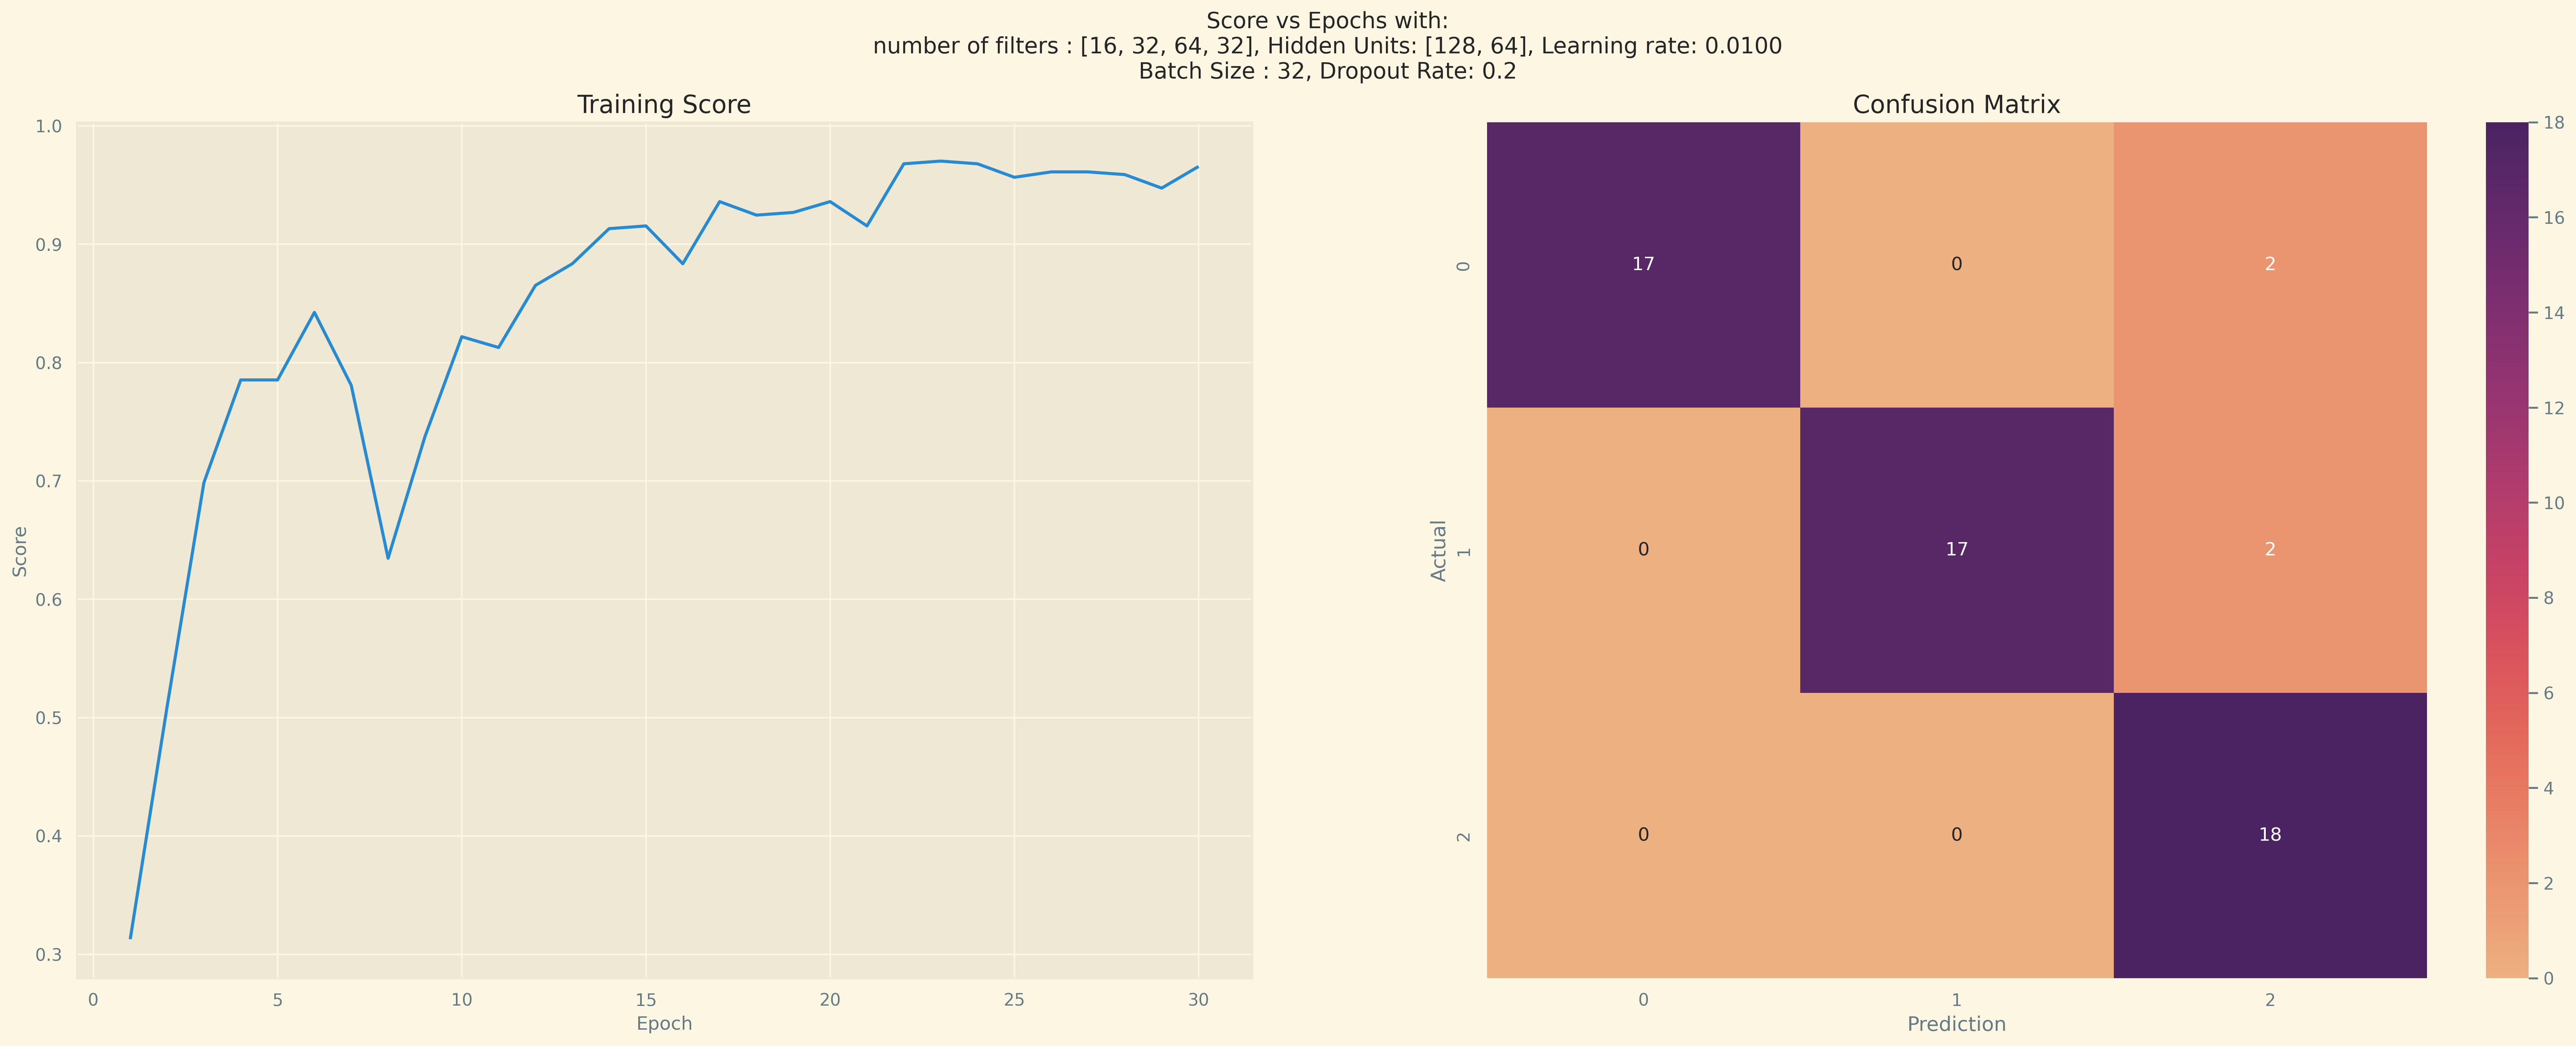

In [ ]:
# confusion matrix and learning curve of the base model
cm_base = confusion_matrix(y_test, class_preds)
fig, ax = plt.subplots(1, 2, figsize=(30, 10), dpi=300)
plot_score_epochs(fig, ax[0], history, num_filters = [16, 32, 64, 32], hidden_units=[128, 64], learning_rate=0.01, batch_size=32, dropout_rate=0.2)
plot_confusion_matrix(cm_base, ax[1], report)

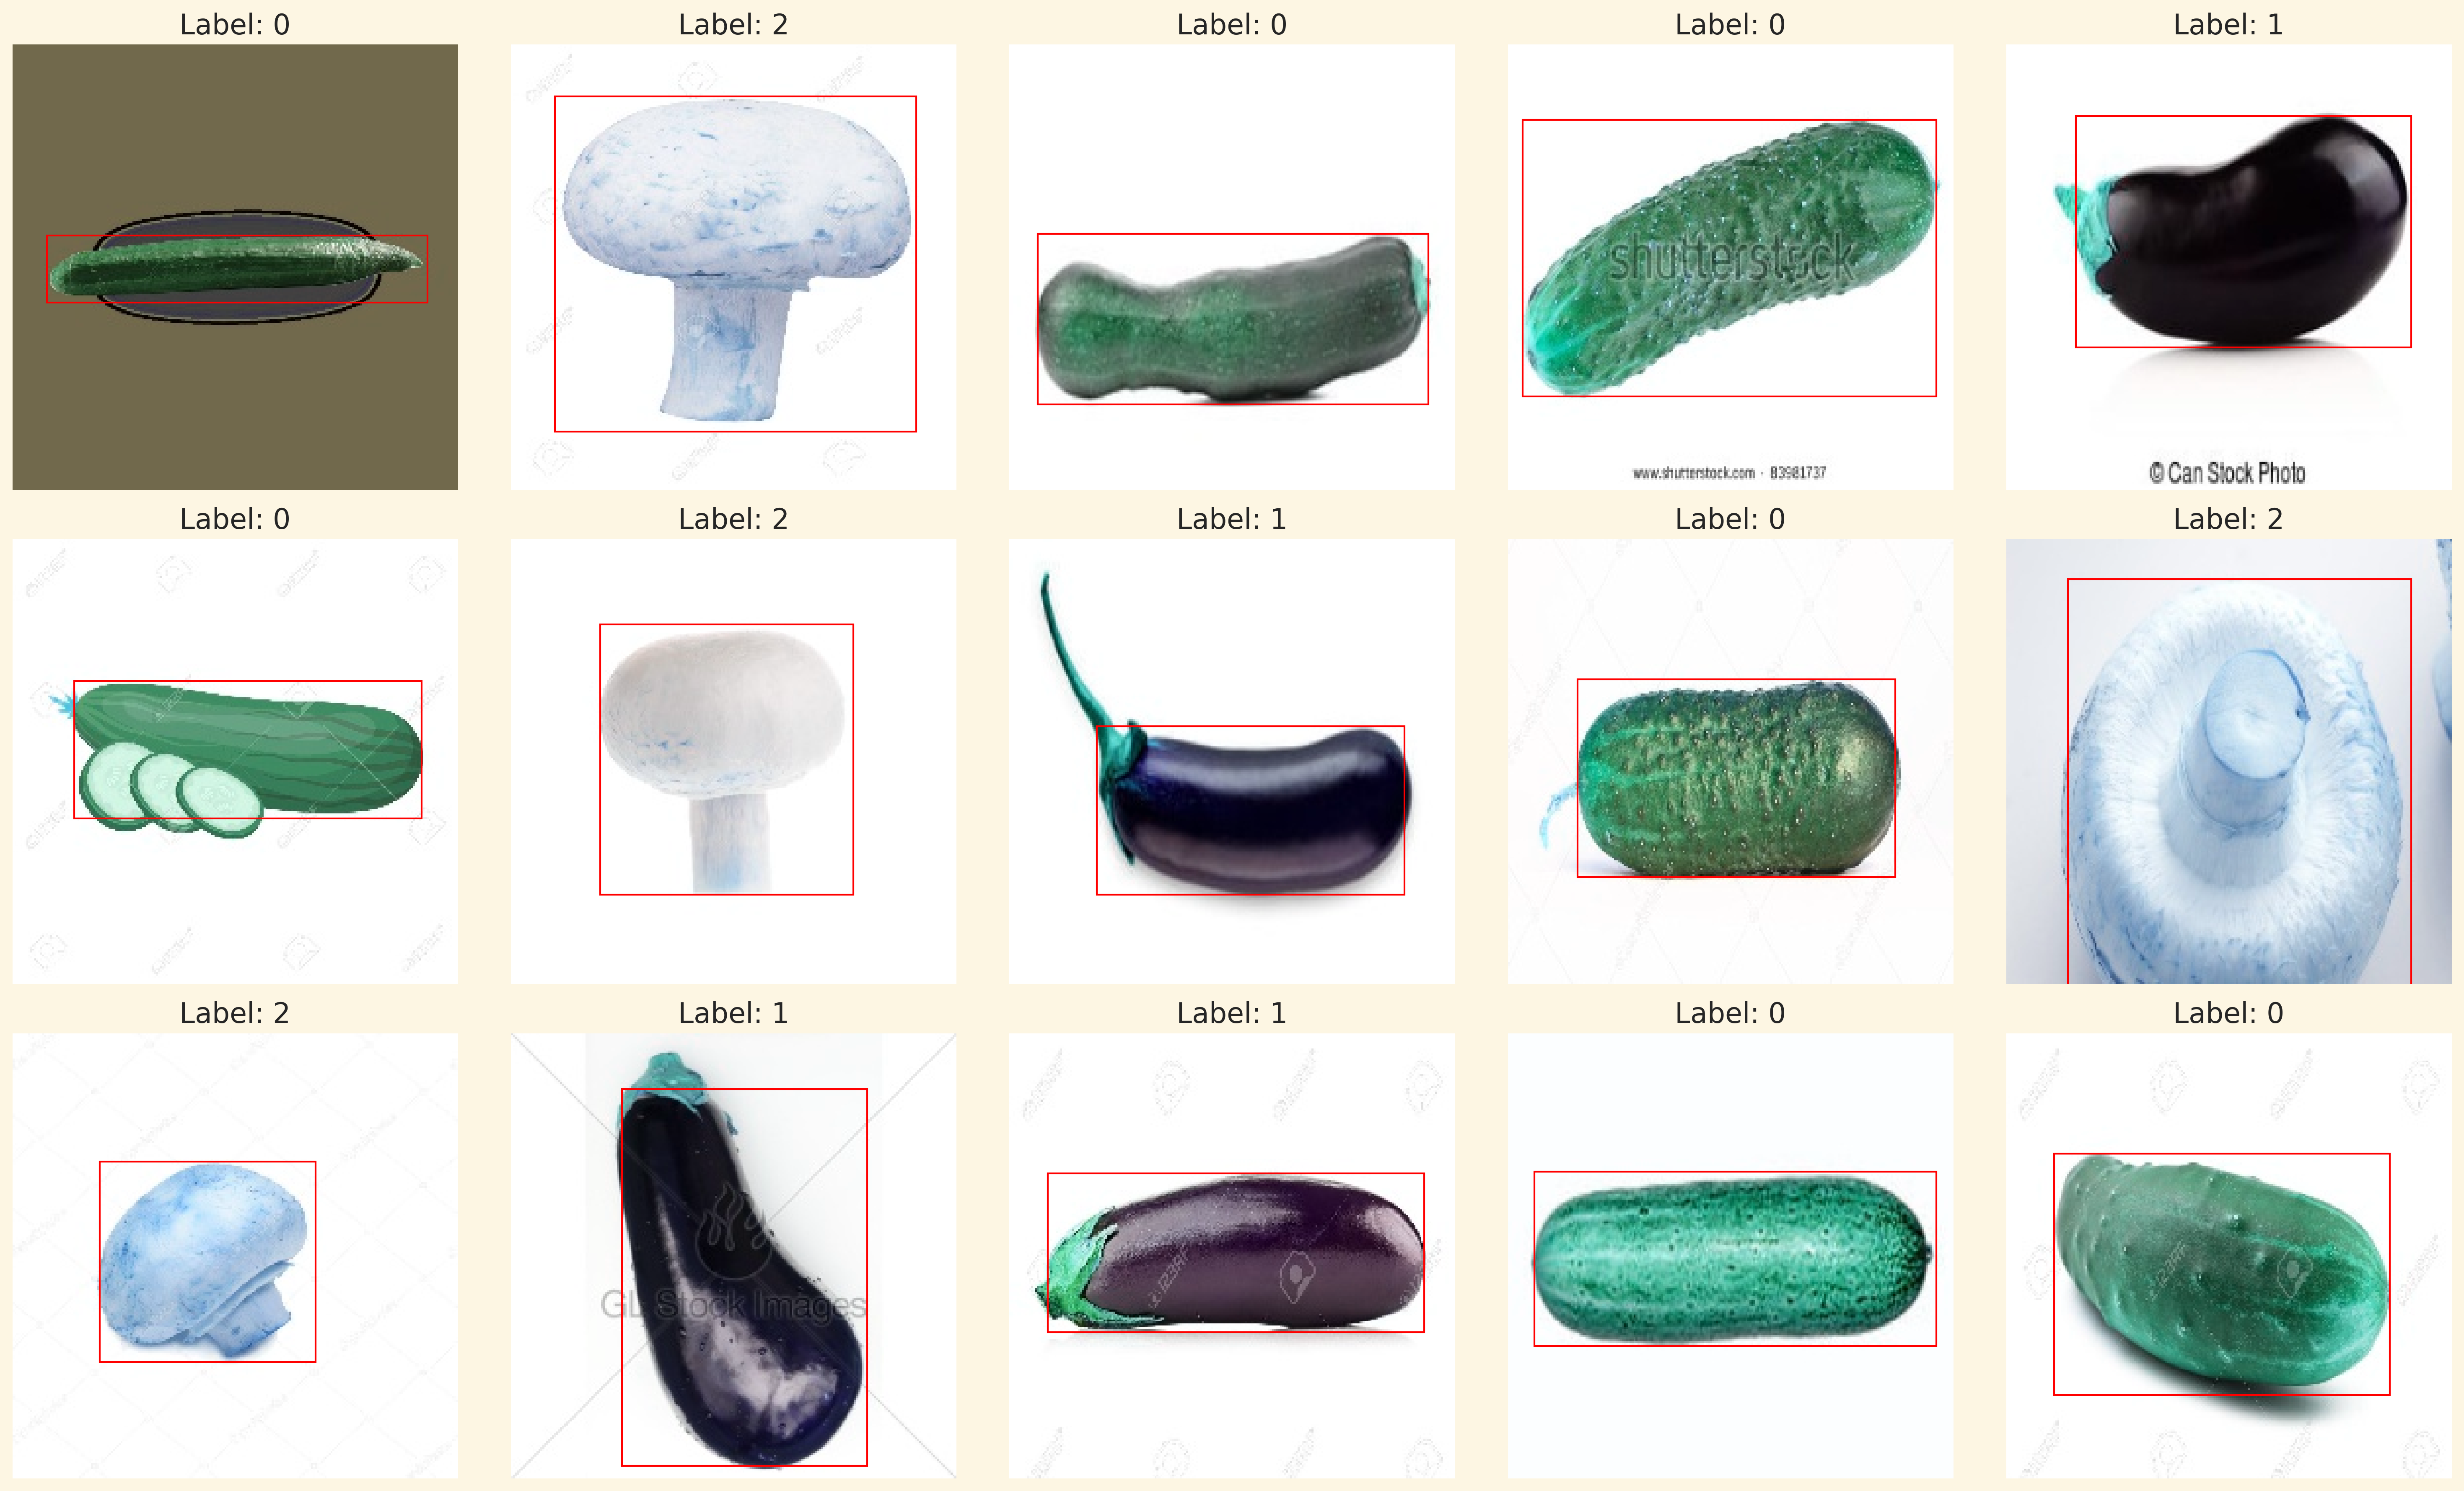

In [ ]:
plot_images(X_test, test_bbox, y_test, 15, test=True)

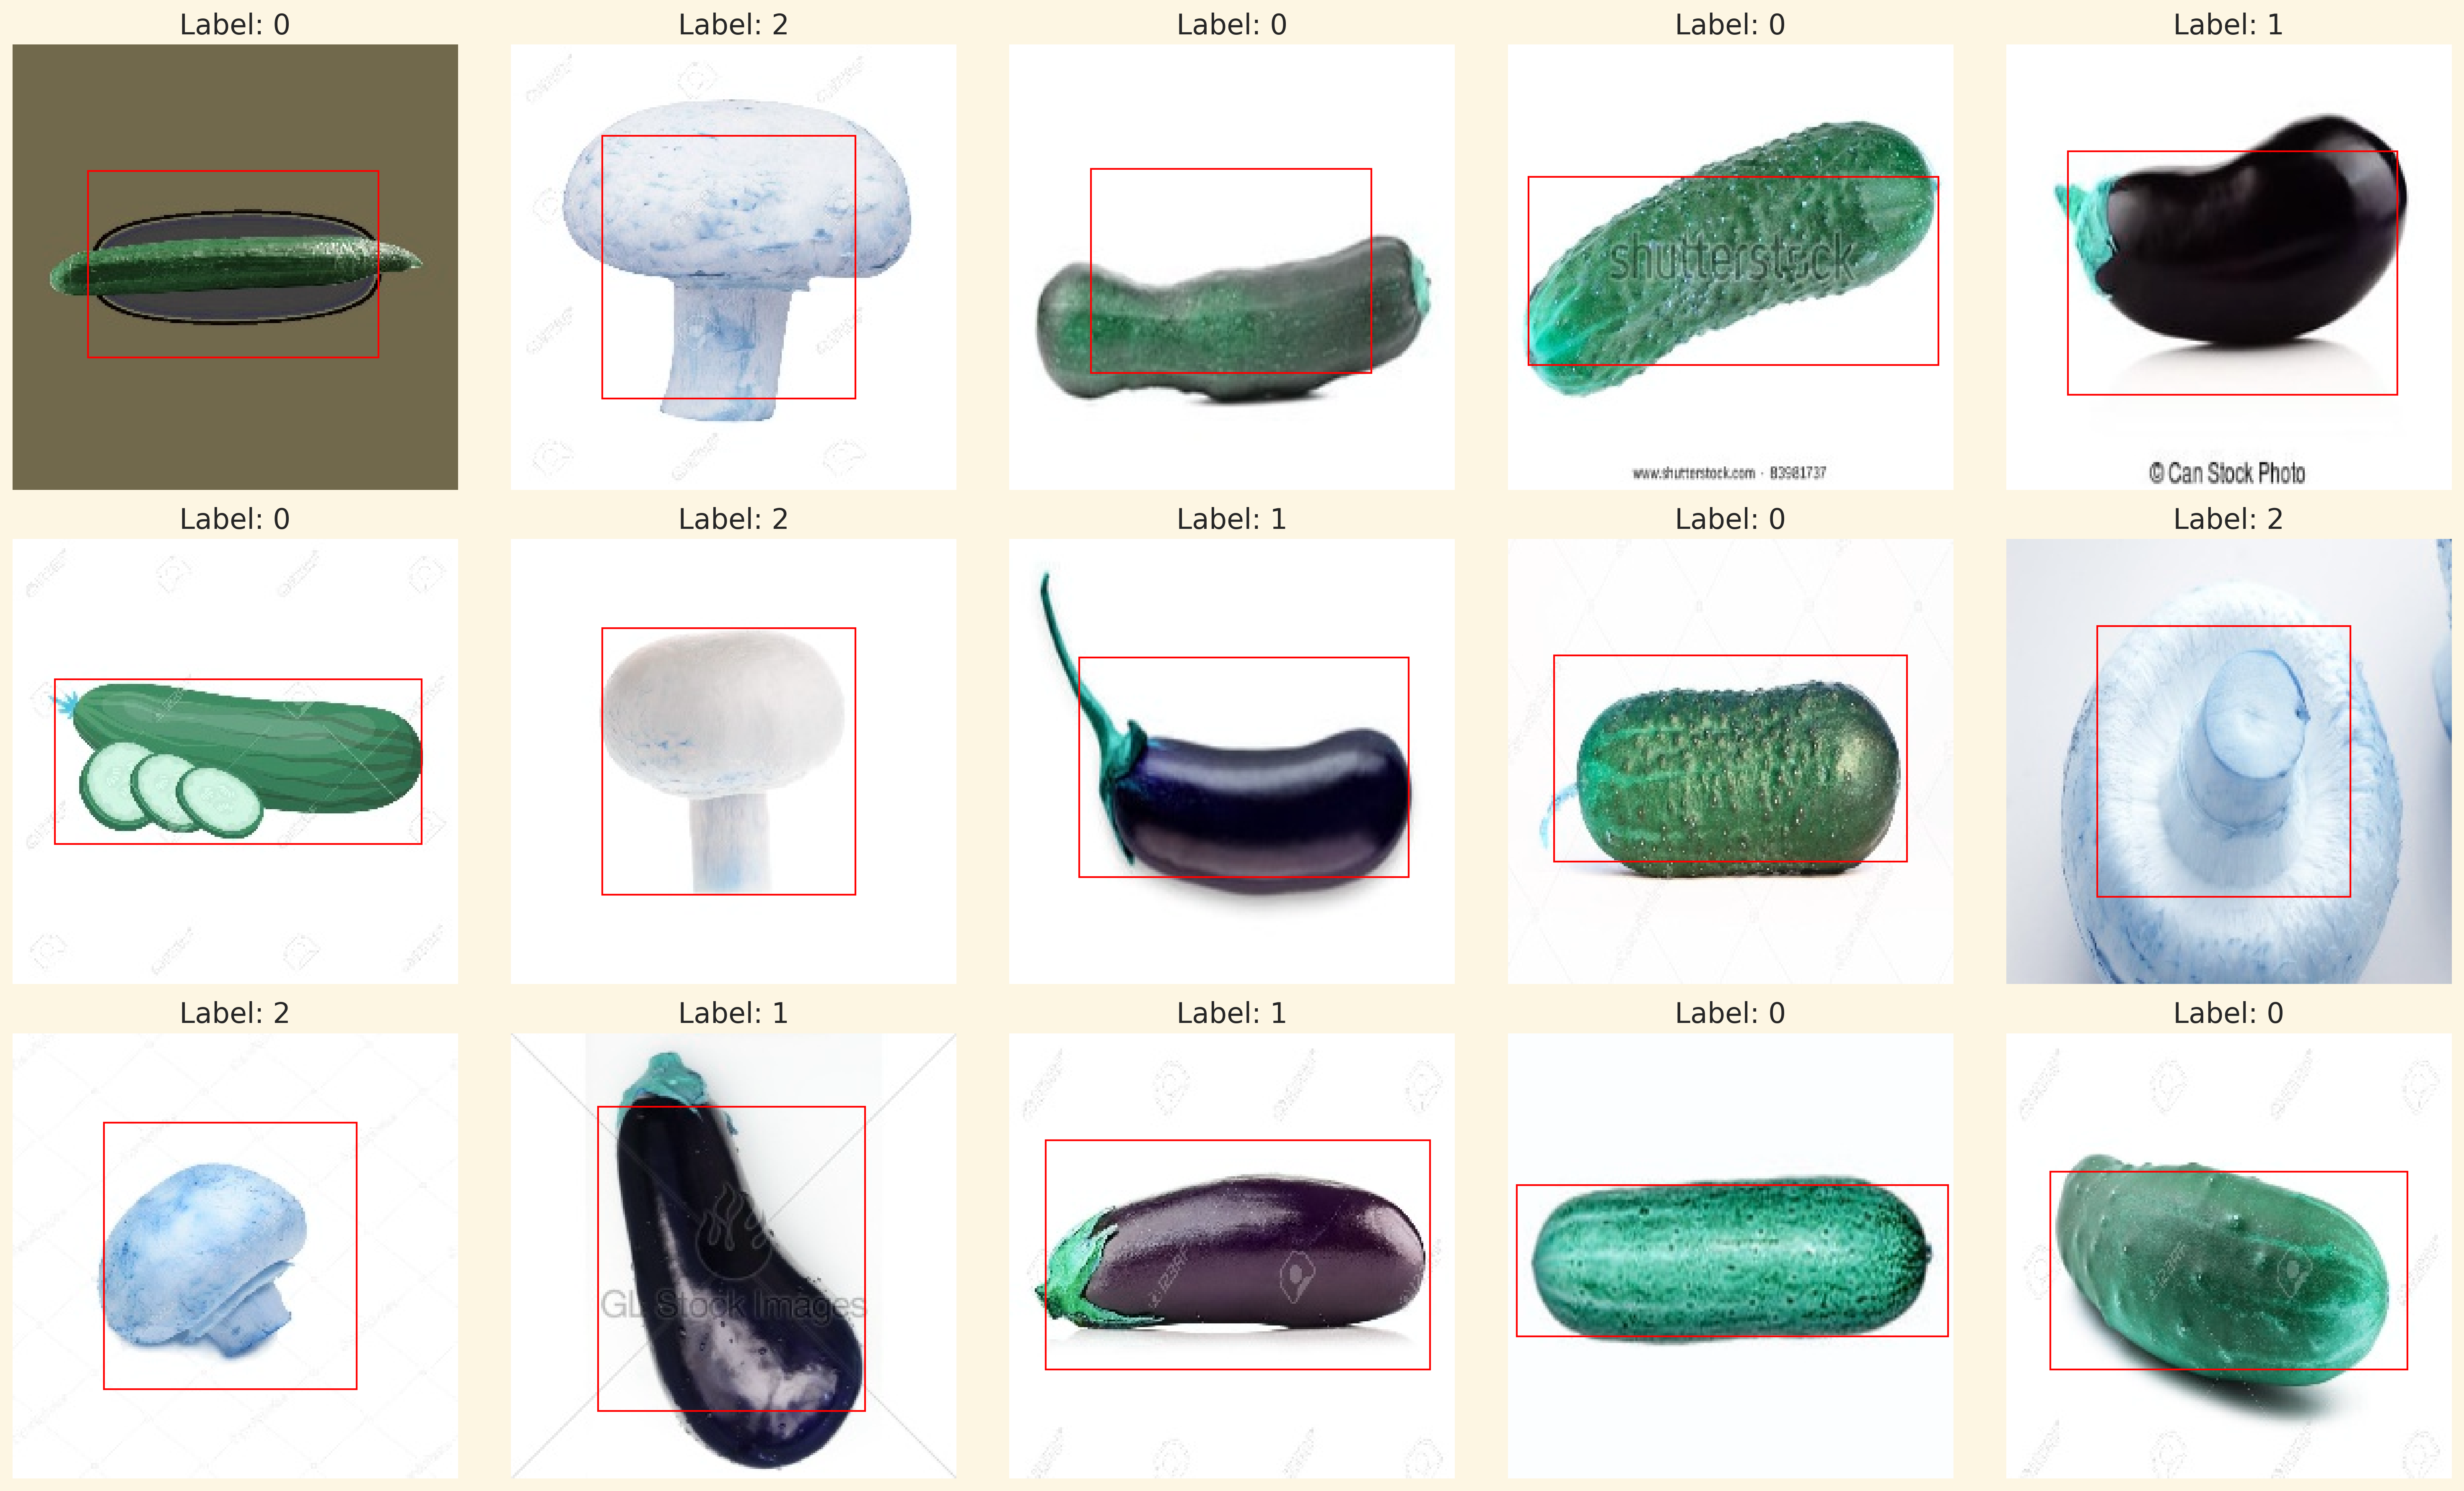

In [ ]:
plot_images(X_test, bbox_pred, class_preds, 15, test=True) # inspecting our predictions with respect to the test set

These were the results with the best model, now I will perform hyperparameter optimization with cross validation to see if we can get better performances.

**Sixth point of the exam:**
For choosing the best model I will be considering as metrics the F1-score for the classification, mainly because we are dealing with multiclass I believed that the harmonic mean between precision and recall might be more accurate to define the model's performance. In the case of the bounding boxes I will be using the difference of the distances between the two coordinates (so just the MSE) between the coordinates. The function will work as follows:

1. it will compute all the possible combinations of the hyperparameters using the `get_params` function
2. Then it will randomly choose 5 combinations from all the possible
3. Then I will update the model using the method update_model of my class
4. I will fit the model and get the scores of the predictions into a dictionary that I will store in a list so that I can sort it later with respect to the best F1-score and MSE
5. At last I will return the best model by returning the first element on the sorted list. (while also returning the report, scores and hyperparameters of the model)

In [ ]:
def get_params(params : Dict[str, List[any]]):
  """
  Utility function to return all the possible combinations of the parameters given as a dictionary of lists
  """
  all_params = []
  keys = list(params.keys())
  for values in product(*params.values()):
      param_dict = {keys[i]: value for i, value in enumerate(values)}
      all_params.append(param_dict)
  return all_params

In [ ]:
def cross_validation(
    X_train : np.array, Y_train : np.array, BBox_train : np.array,
    params : dict, model):
    """
    This function will perform cross validation on the train set
    """

    comb = get_params(params) # getting the combinations
    random_search = [random.choice(comb) for _ in range(5)] # considering only 5 random combinations
    inner_split = StratifiedKFold(n_splits=3) # 3 splits as our dataset it's rather small
    models_performance = []

    for i, (train_index, val_index) in enumerate(inner_split.split(X_train, Y_train)): # getting the index of the splits
        x_train, x_val = X_train[train_index, :], X_train[val_index, :]
        y_train, y_val = Y_train[train_index], Y_train[val_index]
        bbox_train, bbox_val = BBox_train[train_index, :], BBox_train[val_index, :]

        for comb in random_search:
            num_filters = comb['num_filters']
            hidden_units = comb['hidden_units']
            dropout_rate = comb['dropout_rate']
            learning_rate = comb['learning_rate']
            batch_size = comb['batch_size']

            # updating the model
            model = model.update_model(
                num_filters=num_filters,
                hidden_units=hidden_units,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate
            )

            print(f"Training fold {i} with parameters:\n"
                  f"Number of filters: {num_filters}\n"
                  f"Number of hidden units: {hidden_units}\n"
                  f"Dropout Rate: {dropout_rate}\n"
                  f"Batch size: {batch_size}\n"
                  f"Learning Rate: {learning_rate}\n")
            model.print_summary()
            compiled_model = model.model_compile() # compiling the model

            history = compiled_model.fit(
                x=x_train,
                y=[y_train, bbox_train],
                batch_size=batch_size,
                epochs=50
            )

            y_pred, bbox_pred = compiled_model.predict(x_val)
            preds = np.argmax(y_pred, axis=1)
            acc = np.mean([1 if y_val[j] == preds[j] else 0 for j in range(len(preds))])
            mse_bbox = np.mean(np.square(bbox_val - bbox_pred))
            report = class_report(y_val, preds)

            model_dict = {
                'model': (model.model, history),
                'preds': (preds, bbox_pred),
                'scores': (report['weighted avg']['f1-score'], mse_bbox),
                'report': report,
                'hyperparameters': (num_filters, hidden_units, dropout_rate, learning_rate, batch_size)}

            print(f"model's classification accuracy {acc:.2f} and model's f1-score {report['weighted avg']['f1-score']:.2f}")
            print(f"model's bbox mse {mse_bbox:.2f}")
            print('-'*10)

        models_performance.append(model_dict)

        overall_acc = [(model_dict['model'], model_dict['scores'], model_dict['report'], model_dict['hyperparameters']) for model_dict in models_performance]

    overall_sort = sorted(overall_acc, key=lambda x: x[1], reverse=True)
    best_model, best_score, best_report, best_hyperparameters = overall_sort[0][0], overall_sort[0][1], overall_sort[0][2], overall_sort[0][3]

    print(f"Best Model: {best_model}\Best score: {best_score}")
    return best_model, best_score, best_report, best_hyperparameters

**Point 5 on the exam**
- Here I am defining a dictionary with all the hyperparameters I perform hyperparameter optimization with respect to. As written in the exam.

In [ ]:
params = {
    'num_filters' : [[64, 32, 32, 16], [64, 32, 16, 16], [32, 32, 16, 8], [64, 64, 32, 16]],
    'hidden_units' : [[64, 16], [64, 32], [64, 32, 16, 8], [32, 16]],
    'dropout_rate' : np.random.uniform(0.3, 0.6, size=4),
    'learning_rate' : np.random.uniform(0.001, 0.01, size=4),
    'batch_size' : [32, 64, 128]
}


In [ ]:
best_model, best_scores, best_report, best_hyperparameters = cross_validation(X_train, y_train, train_bbox, params, model)

Training fold 0 with parameters:
Number of filters: [32, 32, 16, 8]
Number of hidden units: [64, 32, 16, 8]
Dropout Rate: 0.4123620356542087
Batch size: 32
Learning Rate: 0.0015227525095137954

Model: "Conv_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(32, 227, 227, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (32, 227, 227, 32)           2432      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (32, 114, 114, 32)           0         ['conv2d_4[0][0]']            
 g2D)                                                                                        

In [ ]:
best_model[0].save('best_Model.keras') # saving the best model

In [ ]:
# In case we want to load the best model
# best_model_load = K.models.load_model('/content/MyDrive\EXAM/best_Model.keras')

In [ ]:
best_report

0          1          2  accuracy   macro avg  weighted avg
precision   0.980392   0.918367   0.913043  0.938356    0.937268      0.938320
recall      0.980392   0.937500   0.893617  0.938356    0.937170      0.938356
f1-score    0.980392   0.927835   0.903226  0.938356    0.937151      0.938272
support    51.000000  48.000000  47.000000  0.938356  146.000000    146.000000

In [ ]:
best_scores

(0.9382718861469357, 0.026759902)

In [ ]:
b_num_filters, b_hidden_units, b_dropout_rate, b_learning_rate, b_batch_size = best_hyperparameters

In [ ]:
# Testing the best model with our test set
# best_pred_class, best_pred_bbox = best_model_load.predict(X_test) In case we were using the loaded model
best_pred_class, best_pred_bbox = best_model[0].predict(X_test)
best_preds = np.argmax(best_pred_class, axis=1)

2/2 [==============================] - 1s 723ms/step


In [ ]:
test_report = class_report(y_test, best_preds)
test_report

0          1          2  accuracy  macro avg  weighted avg
precision   1.000000   0.950000   0.944444  0.964286   0.964815      0.965179
recall      0.947368   1.000000   0.944444  0.964286   0.963938      0.964286
f1-score    0.972973   0.974359   0.944444  0.964286   0.963925      0.964273
support    19.000000  19.000000  18.000000  0.964286  56.000000     56.000000

These are the results of the best model. Overall the models did not performed exceptionally and this might be due to several reasons:
  1. Low number of epochs, perhaps considering a higher number will help the model to converge to a minimum or minimize the loss as much as possible. Specially for the MSE as maybe it would need more iterations to get the right number for the coordinates. (but because of running times I didn't want to consider a high number of epochs)
  2. The number of possible combinations that are being considered. I only took 5 out of all the possible ones (64), to reduce running times
  3. The task it's not the easiest as many of the images resemble to one another, even though with data augmentation I managed to increase the capabilities of my model by showing it more training examples.

Also I will like to point out that I consider to have done a good job with overfitting as the generalization capabilities of the model seem to be performing very good. So all the regularization techniques I've used seem to be helping the model a lot.

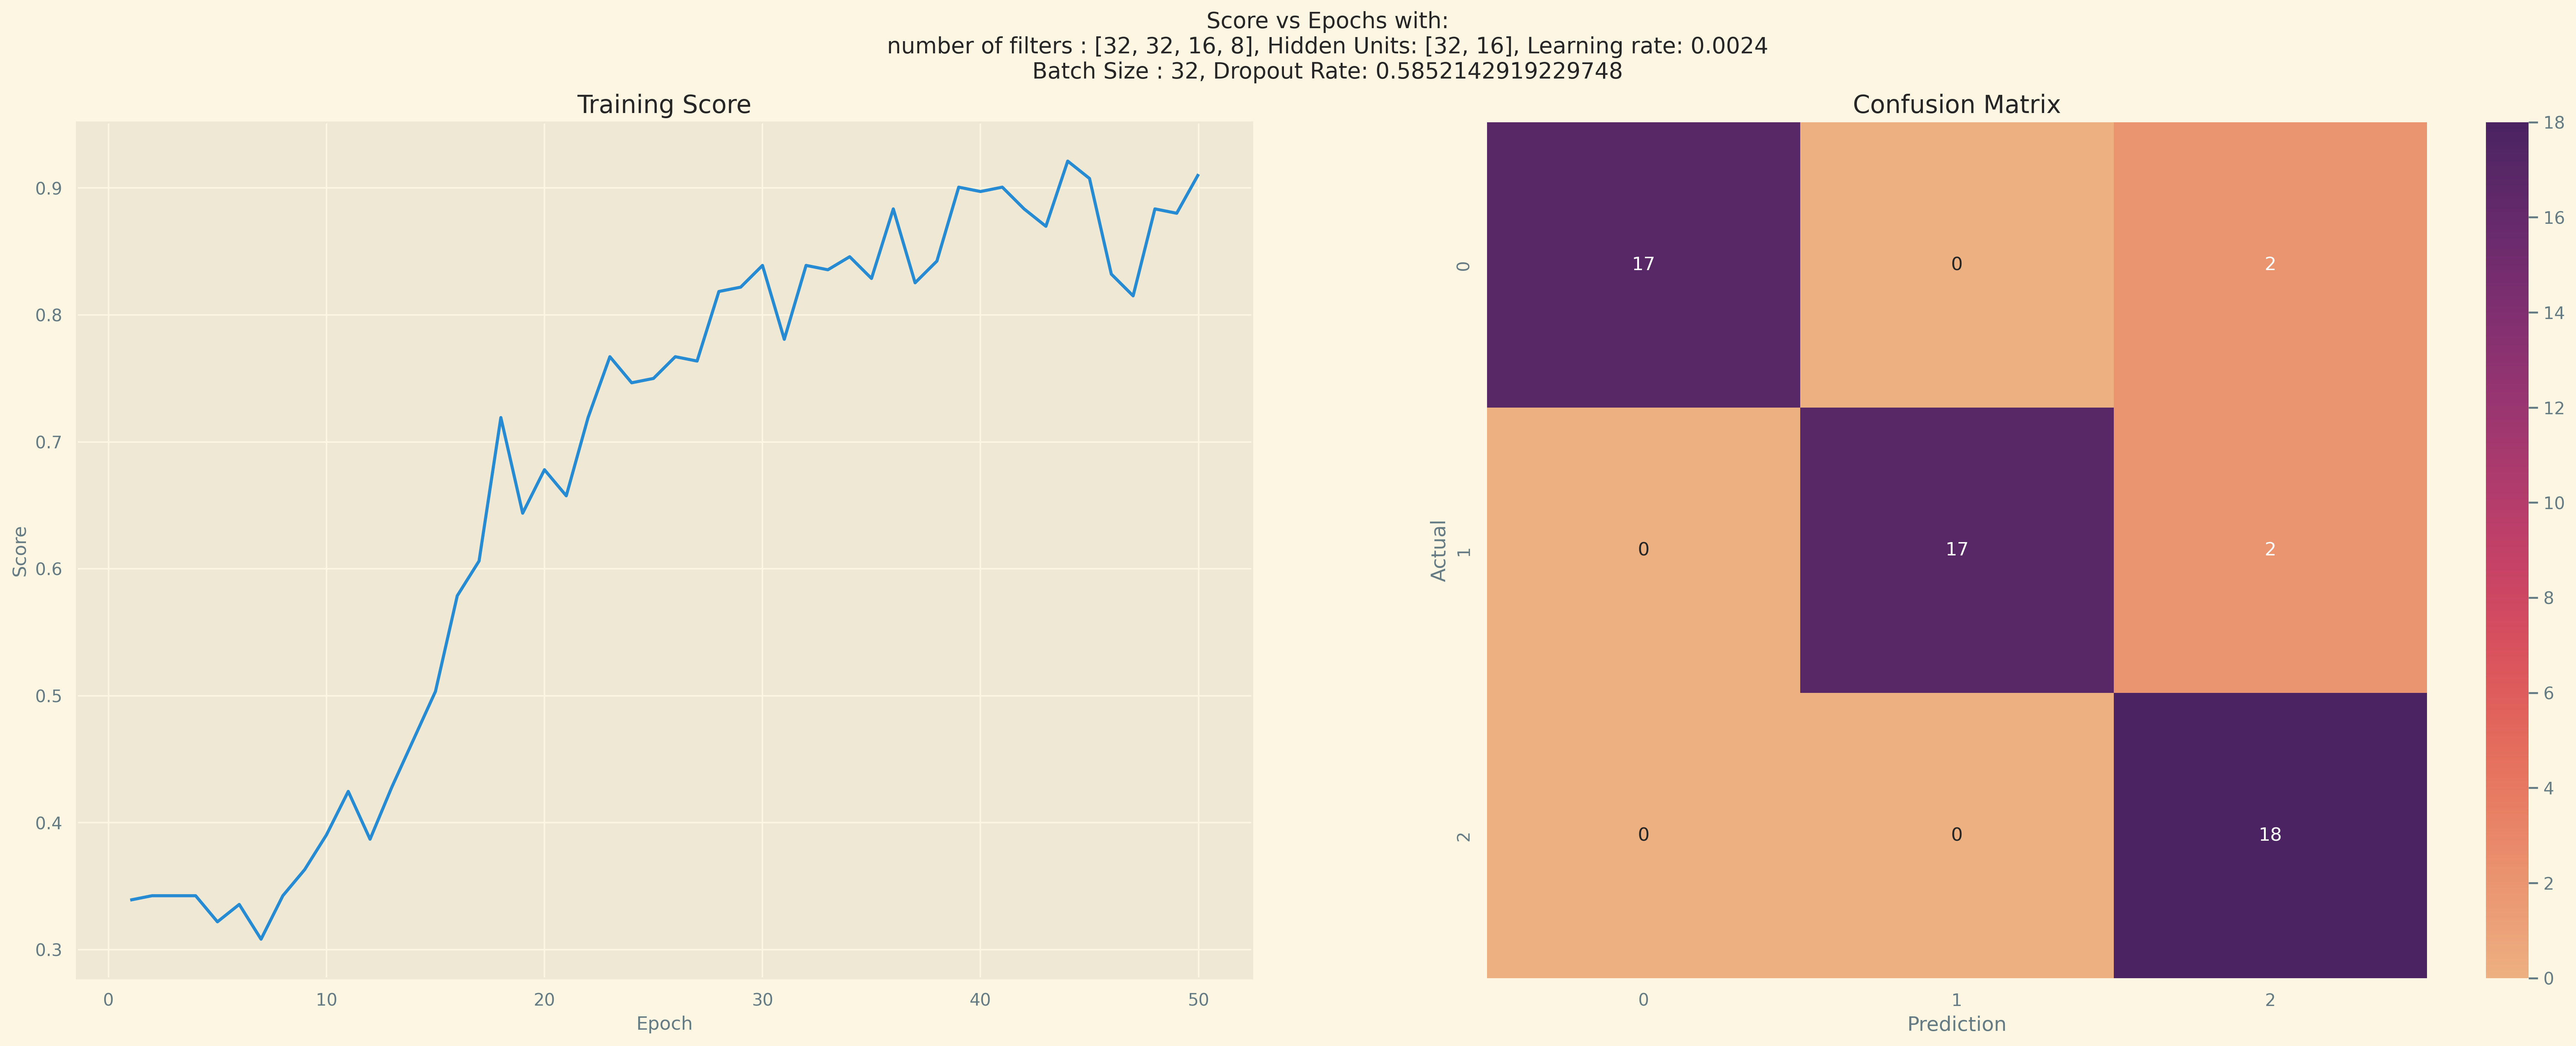

In [ ]:
cm_best = confusion_matrix(y_test, best_preds)
fig, ax = plt.subplots(1, 2, figsize=(30, 10), dpi=300)
plot_score_epochs(fig, ax[0], best_model[1], num_filters=b_num_filters, hidden_units=b_hidden_units, learning_rate=b_learning_rate, batch_size=b_batch_size, dropout_rate=b_dropout_rate)
plot_confusion_matrix(cm_base, ax[1], report)

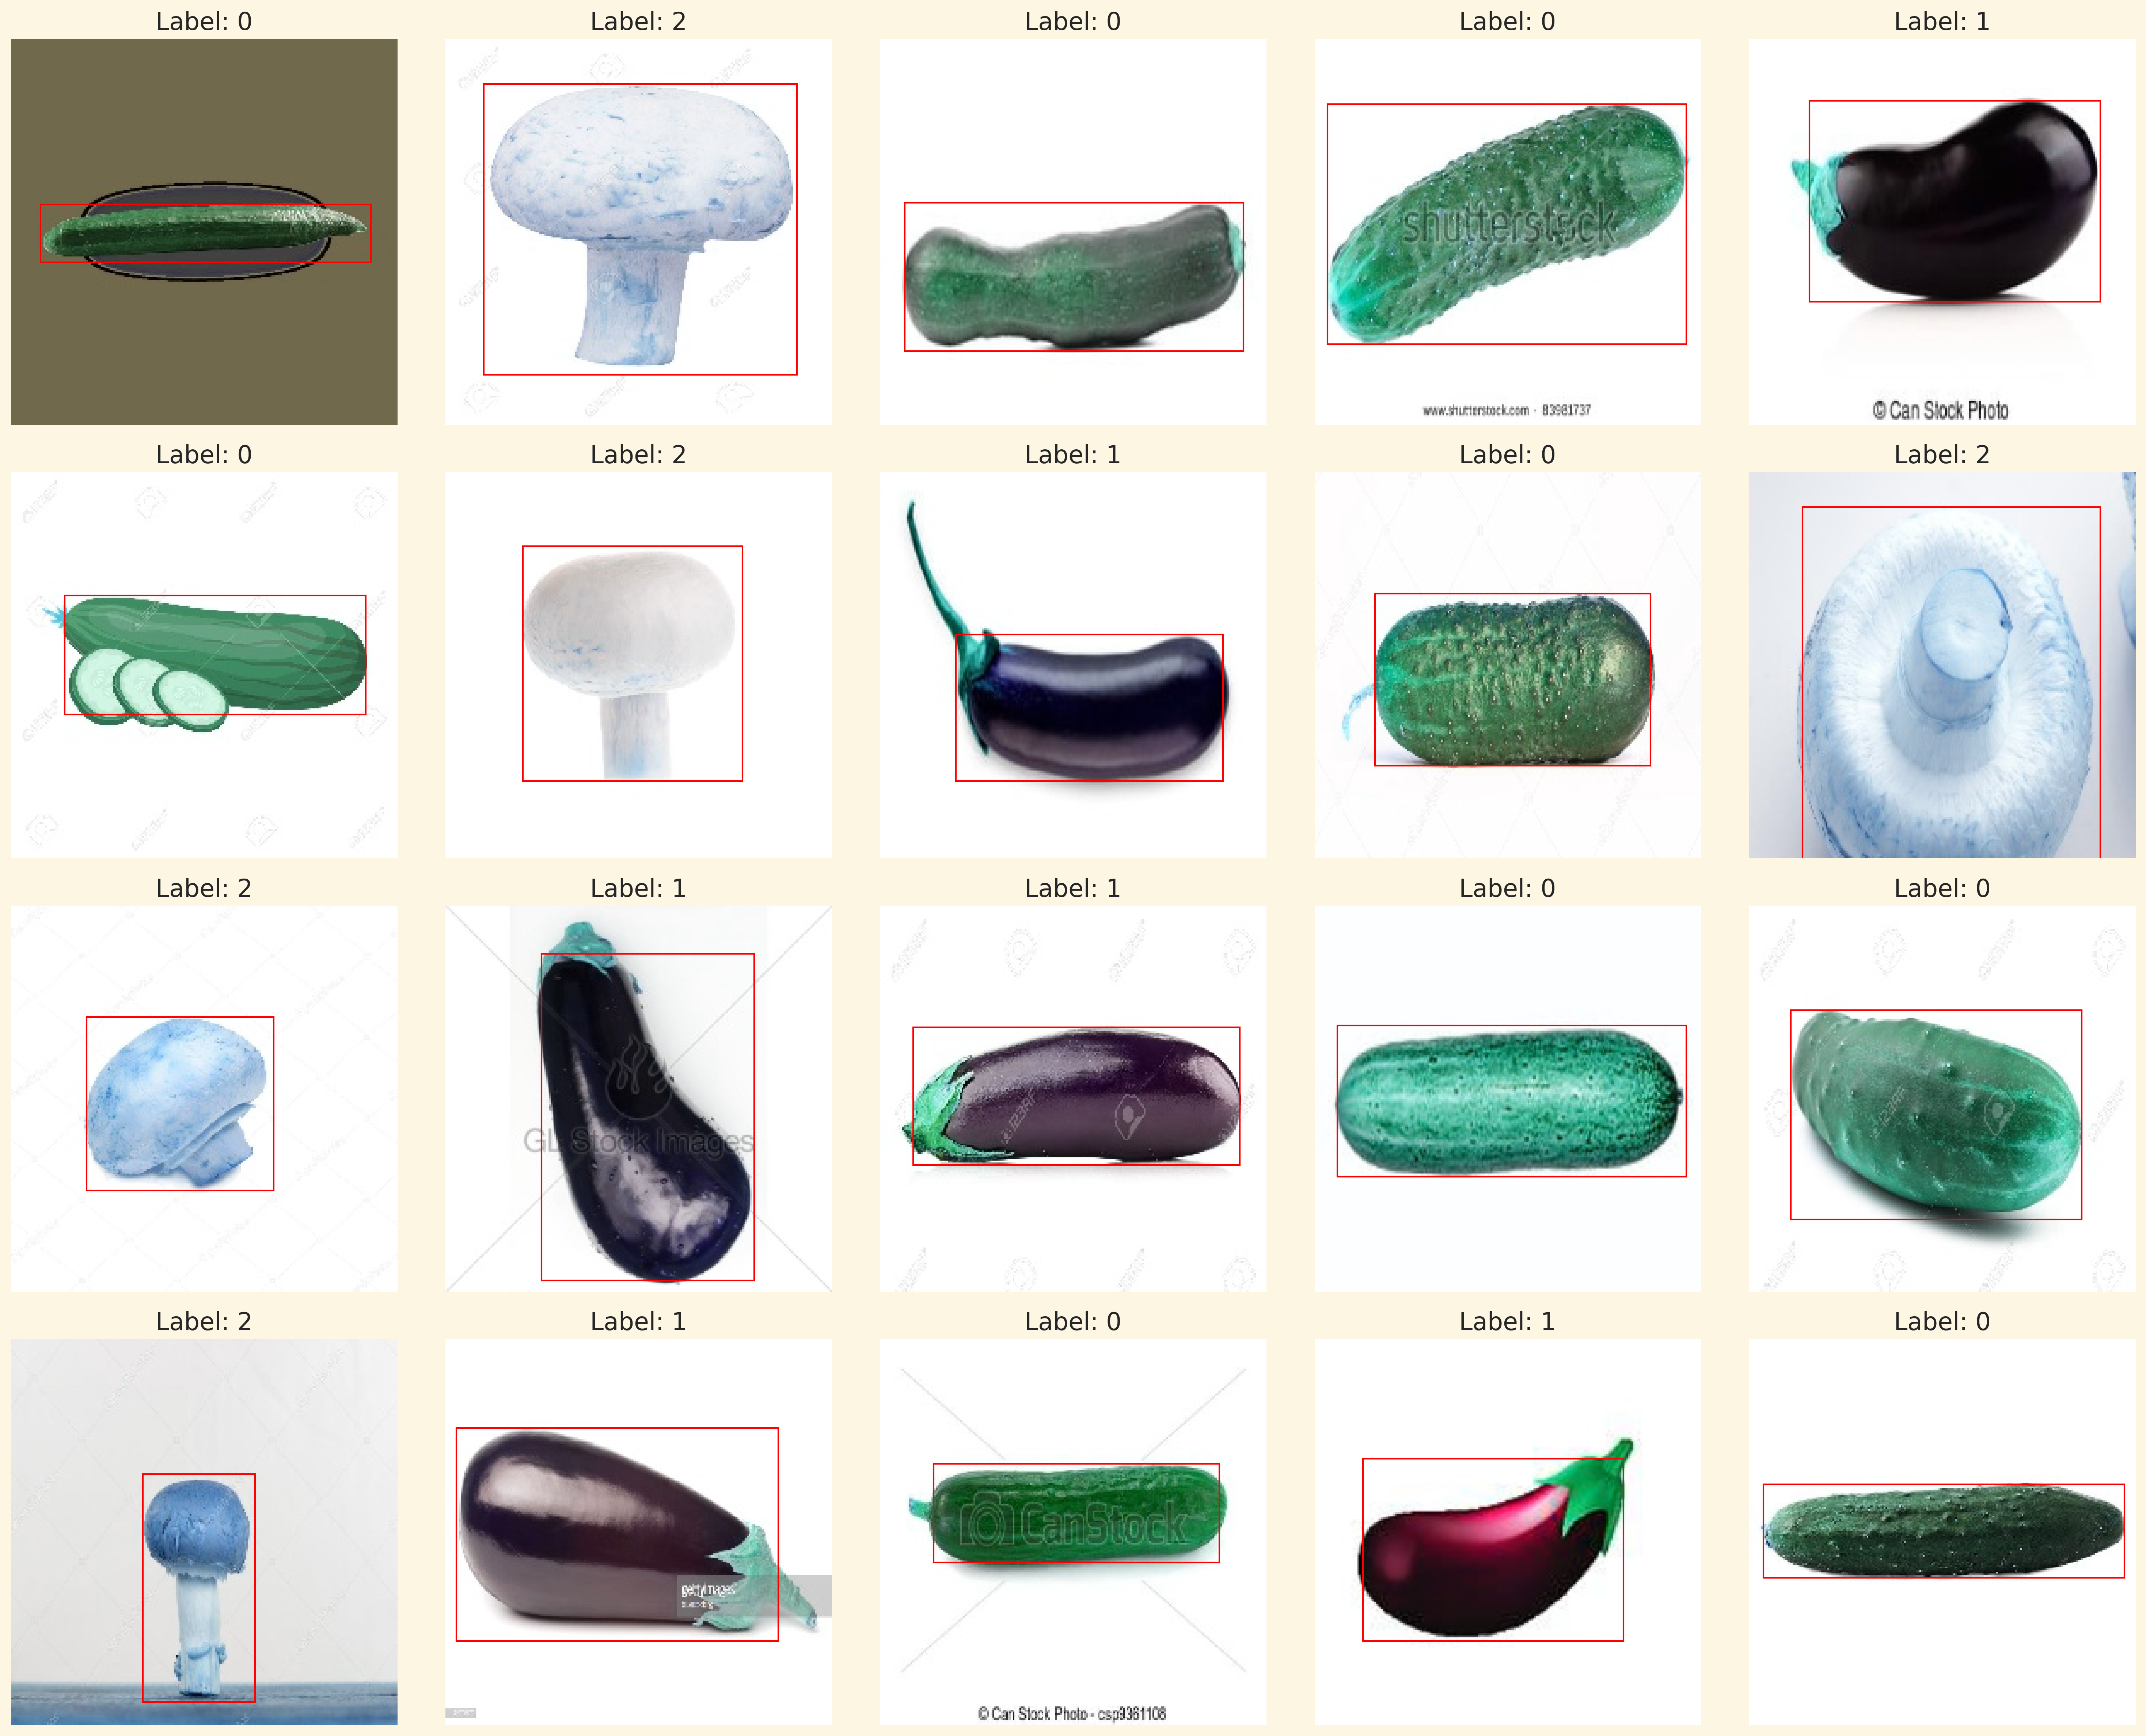

In [ ]:
plot_images(X_test, test_bbox, y_test, 20, test=True)

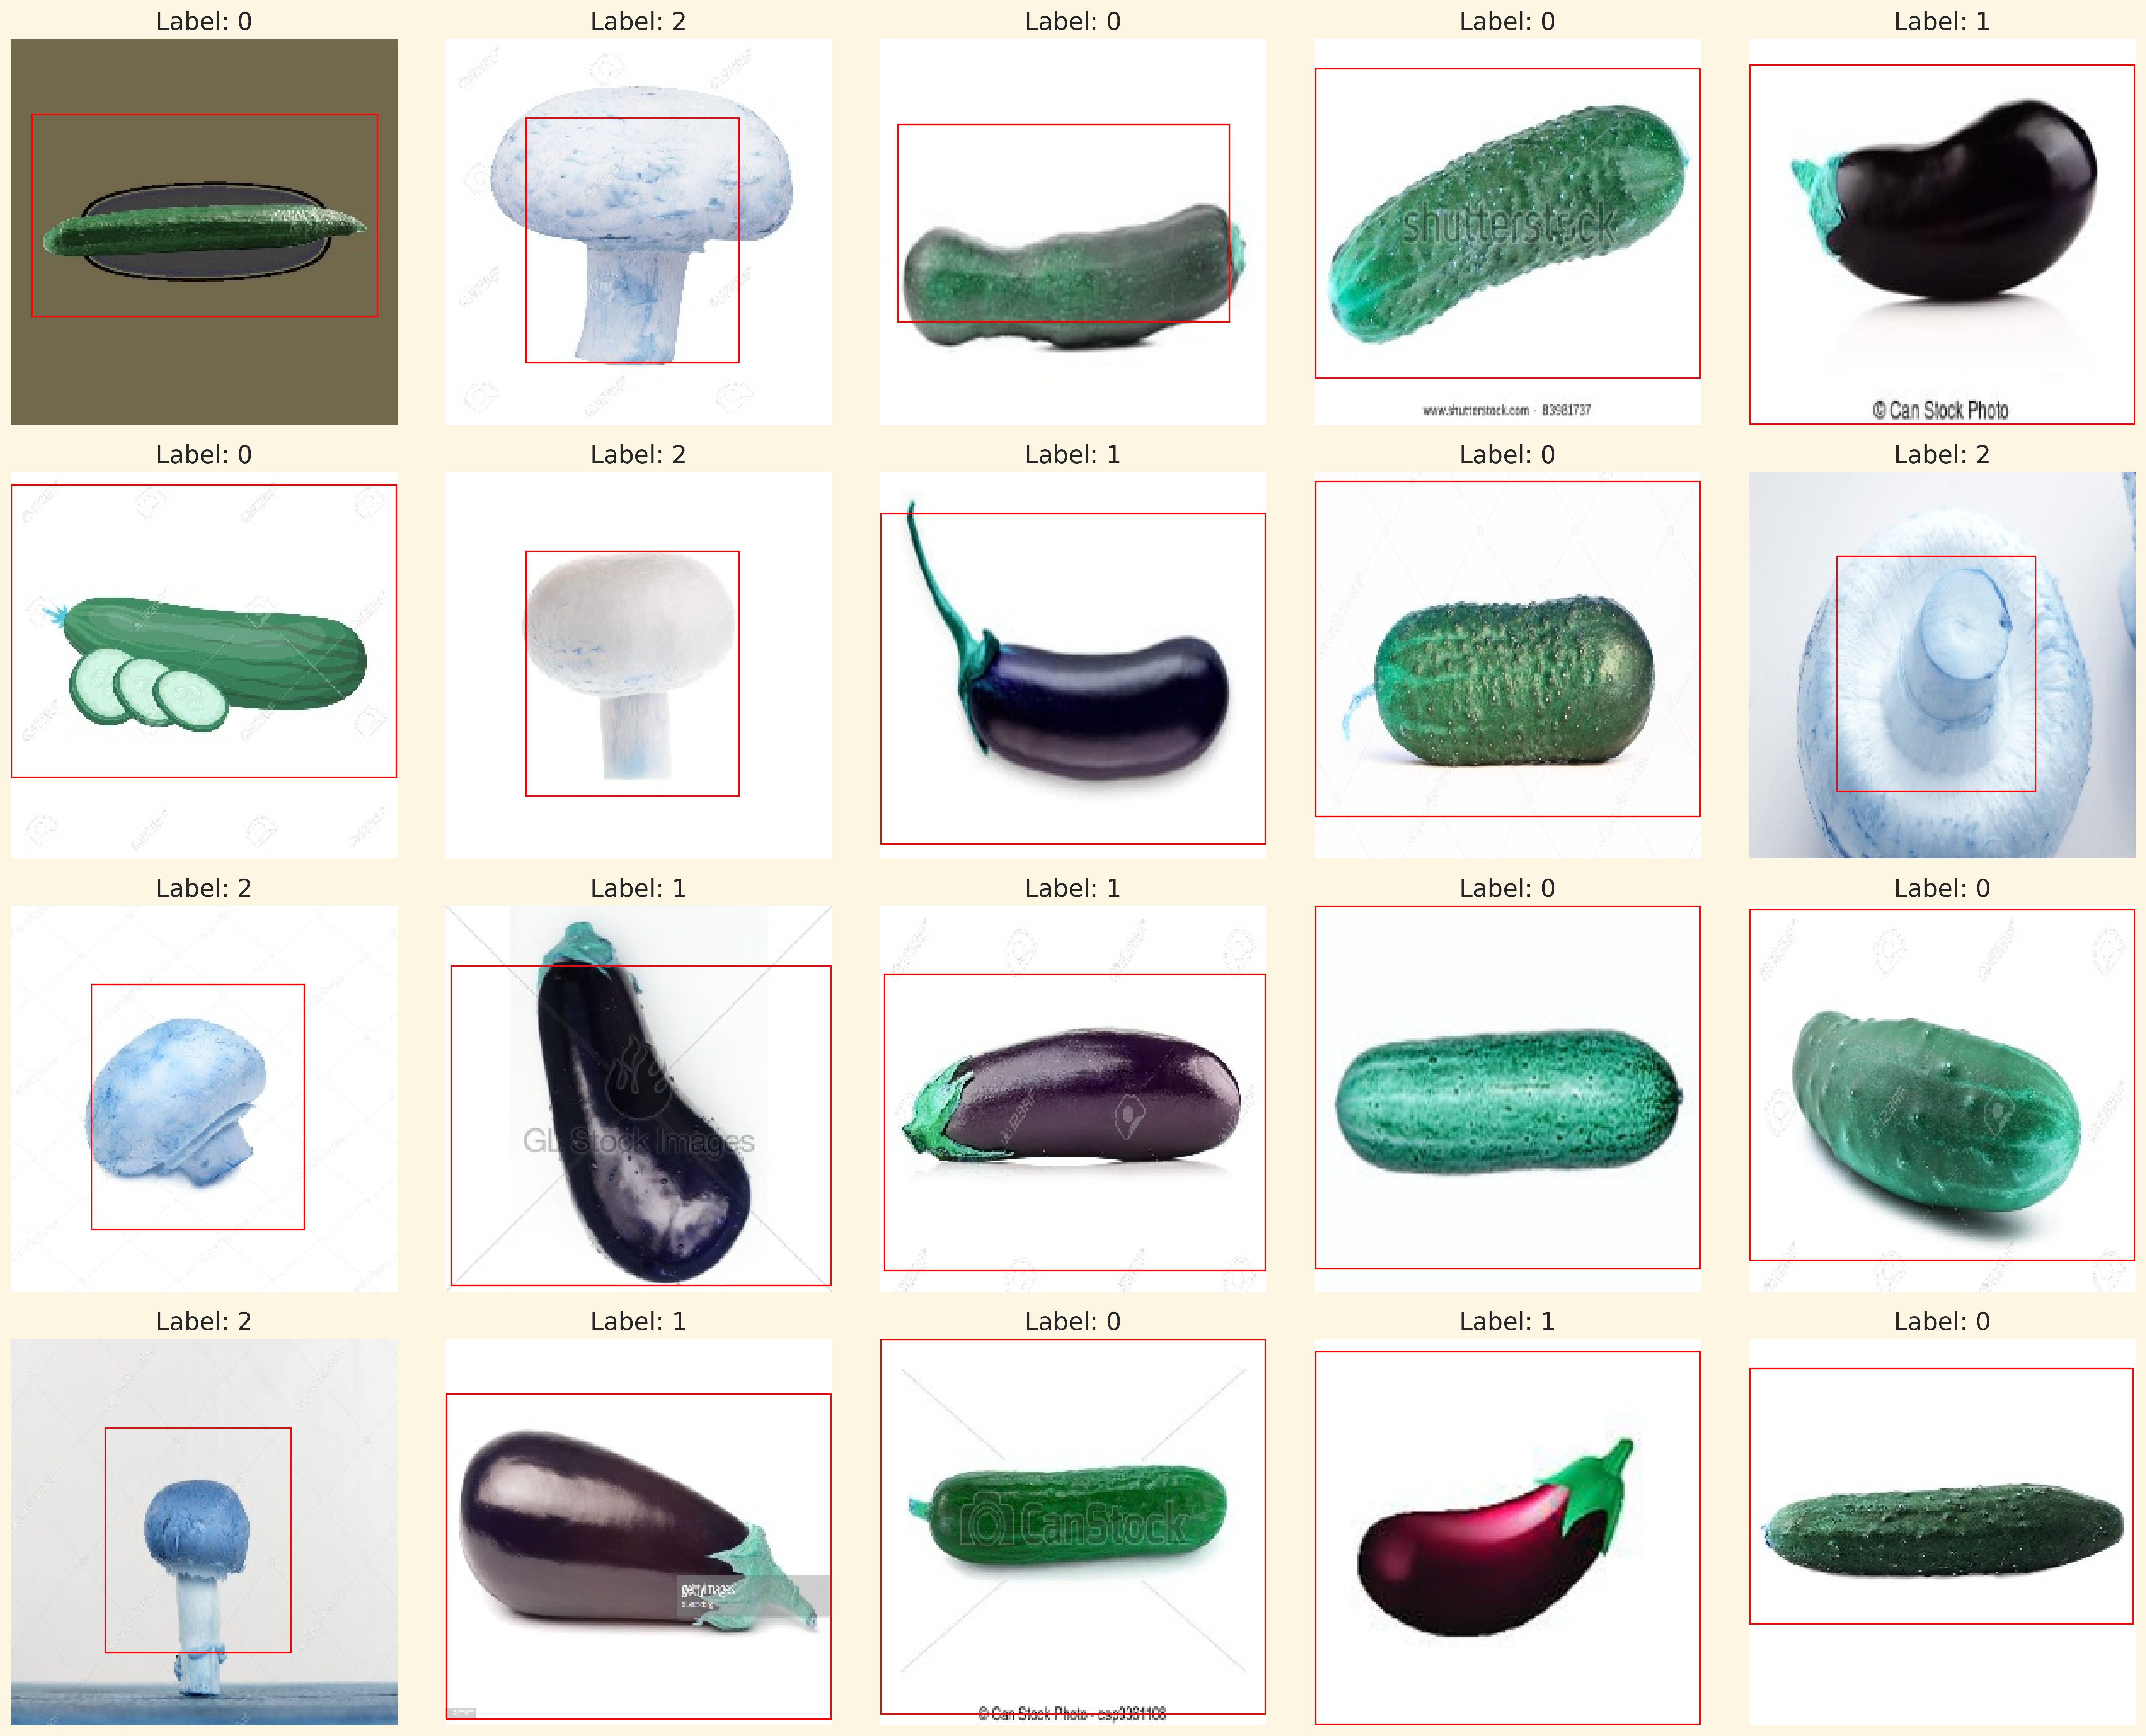

In [ ]:
plot_images(X_test, best_pred_bbox, best_preds, 20, test=True)